In [110]:
# Import necessary dependencies
from requests import get
from json import dump, load
from time import sleep
from os import listdir
from typing import List, Dict
from copy import deepcopy
import matplotlib.pyplot as plt

### Match Parsing

#### Sample of random matches

In [25]:
def get_matches_sample(
        min_rank: int = None,
        max_rank: int = None,
        mmr_ascending: int = None,
        mmr_descending: int = None,
        less_than_match_id: int = None,
        api_link: str = "https://api.opendota.com/api/publicMatches",
) -> List[Dict]:
    """
    Get a sample of 100 random matches from 'https://api.opendota.com/api/publicMatches' or 
    from the different API specifed in `api_link`.

    Parameters
    ----------
    min_rank: int
        Minimum rank for the matches. 
        Ranks are represented by integers (10-15: Herald, 20-25: Guardian, 30-35: Crusader, 40-45: Archon, 
        50-55: Legend, 60-65: Ancient, 70-75: Divine, 80-85: Immortal). 
        Each increment represents an additional star.
    max_rank: int
        Maximum rank for the matches. 
        Ranks are represented by integers (10-15: Herald, 20-25: Guardian, 30-35: Crusader, 40-45: Archon, 
        50-55: Legend, 60-65: Ancient, 70-75: Divine, 80-85: Immortal). 
        Each increment represents an additional star.
    mmr_ascending: int
        Order by average rank ascending.
    mmr_descending: int
        Order by average rank descending.
    api_link: str
        Link to the API where requests should be sent.
    
    Returns
    ----------
    response: list[dict]
        Information about 100 sampled matches. [Output format description](https://docs.opendota.com/#tag/public-matches/operation/get_public_matches).
    """

    response = get(
        api_link,
        params={
            "less_than_match_id": less_than_match_id,
            "min_rank": min_rank,
            "max_rank": max_rank,
            "mmr_ascending": mmr_ascending,
            "mmr_descending": mmr_descending,
        }
    )

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to retrieve data, status code: {response.status_code}")
        return []

In [26]:
# download matches with rating from 0 to 100
for rank in range(100):
    print(rank)
    matches = get_matches_sample(rank, rank)
    for match in matches:
        with open(f'data/matches/{match["match_id"]}.json', 'w') as f:
            dump(match, f)
    sleep(1.5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [111]:
# calculate winrate for each hero
winrate = {}
for match in listdir('data/matches'):
    with open(f'data/matches/{match}') as f:
        match = load(f)
    rank = match['avg_rank_tier'] // 10
    win = match['radiant_win']
    for hero in match['radiant_team']:
        if hero not in winrate:
            winrate[hero] = {}
        if rank not in winrate[hero]:
            # [lose, win]
            winrate[hero][rank] = [0, 0]
        winrate[hero][rank][win] += 1
    for hero in match['dire_team']:
        if hero not in winrate:
            winrate[hero] = {}
        if rank not in winrate[hero]:
            # [lose, win]
            winrate[hero][rank] = [0, 0]
        winrate[hero][rank][1 - win] += 1

In [112]:
# translate [lose, win] to winrate
for hero in winrate:
    for rank in winrate[hero]:
        winrate[hero][rank] = winrate[hero][rank][1] / sum(winrate[hero][rank])

In [113]:
# normalize winrate
for hero in winrate:
    rates = sorted(winrate[hero].keys())
    rates = [rates[0] - 1] + rates + [rates[-1] + 1]
    winrate[hero][rates[0]] = 0.5
    winrate[hero][rates[-1]] = 0.5
    rts = deepcopy(winrate[hero])
    for i in range(1, len(rates) - 1):
        winrate[hero][rates[i]] = (rts[rates[i - 1]] + rts[rates[i]] * 2 + rts[rates[i + 1]]) / 4

In [114]:
winrate

{30: {1: 0.5382311677099072,
  6: 0.49878277153558054,
  7: 0.4916666666666667,
  5: 0.5393924661480841,
  4: 0.5746409187646955,
  2: 0.5562682625113434,
  3: 0.5756455547259858,
  8: 0.5,
  0: 0.5,
  9: 0.5},
 23: {1: 0.46747311827956994,
  6: 0.3382352941176471,
  7: 0.3125,
  5: 0.3125,
  4: 0.29298642533936653,
  3: 0.30558069381598796,
  2: 0.40392886683209267,
  8: 0.25,
  0: 0.5,
  9: 0.5},
 28: {1: 0.44166666666666665,
  6: 0.4556173820879703,
  7: 0.5024509803921569,
  5: 0.4723802750118539,
  3: 0.4493107769423559,
  2: 0.4720238095238095,
  4: 0.4536086838718417,
  8: 0.5220588235294118,
  0: 0.5,
  9: 0.5},
 84: {1: 0.5986536226268888,
  6: 0.5031512605042017,
  7: 0.547077922077922,
  5: 0.48221614227086185,
  4: 0.5237938340395716,
  2: 0.5961718373479744,
  3: 0.5631831275851301,
  8: 0.5405844155844155,
  0: 0.5,
  9: 0.5},
 63: {1: 0.49745652978172406,
  7: 0.5066380718954249,
  6: 0.5586004273504274,
  5: 0.5300480769230769,
  4: 0.5245726495726496,
  2: 0.5383771118

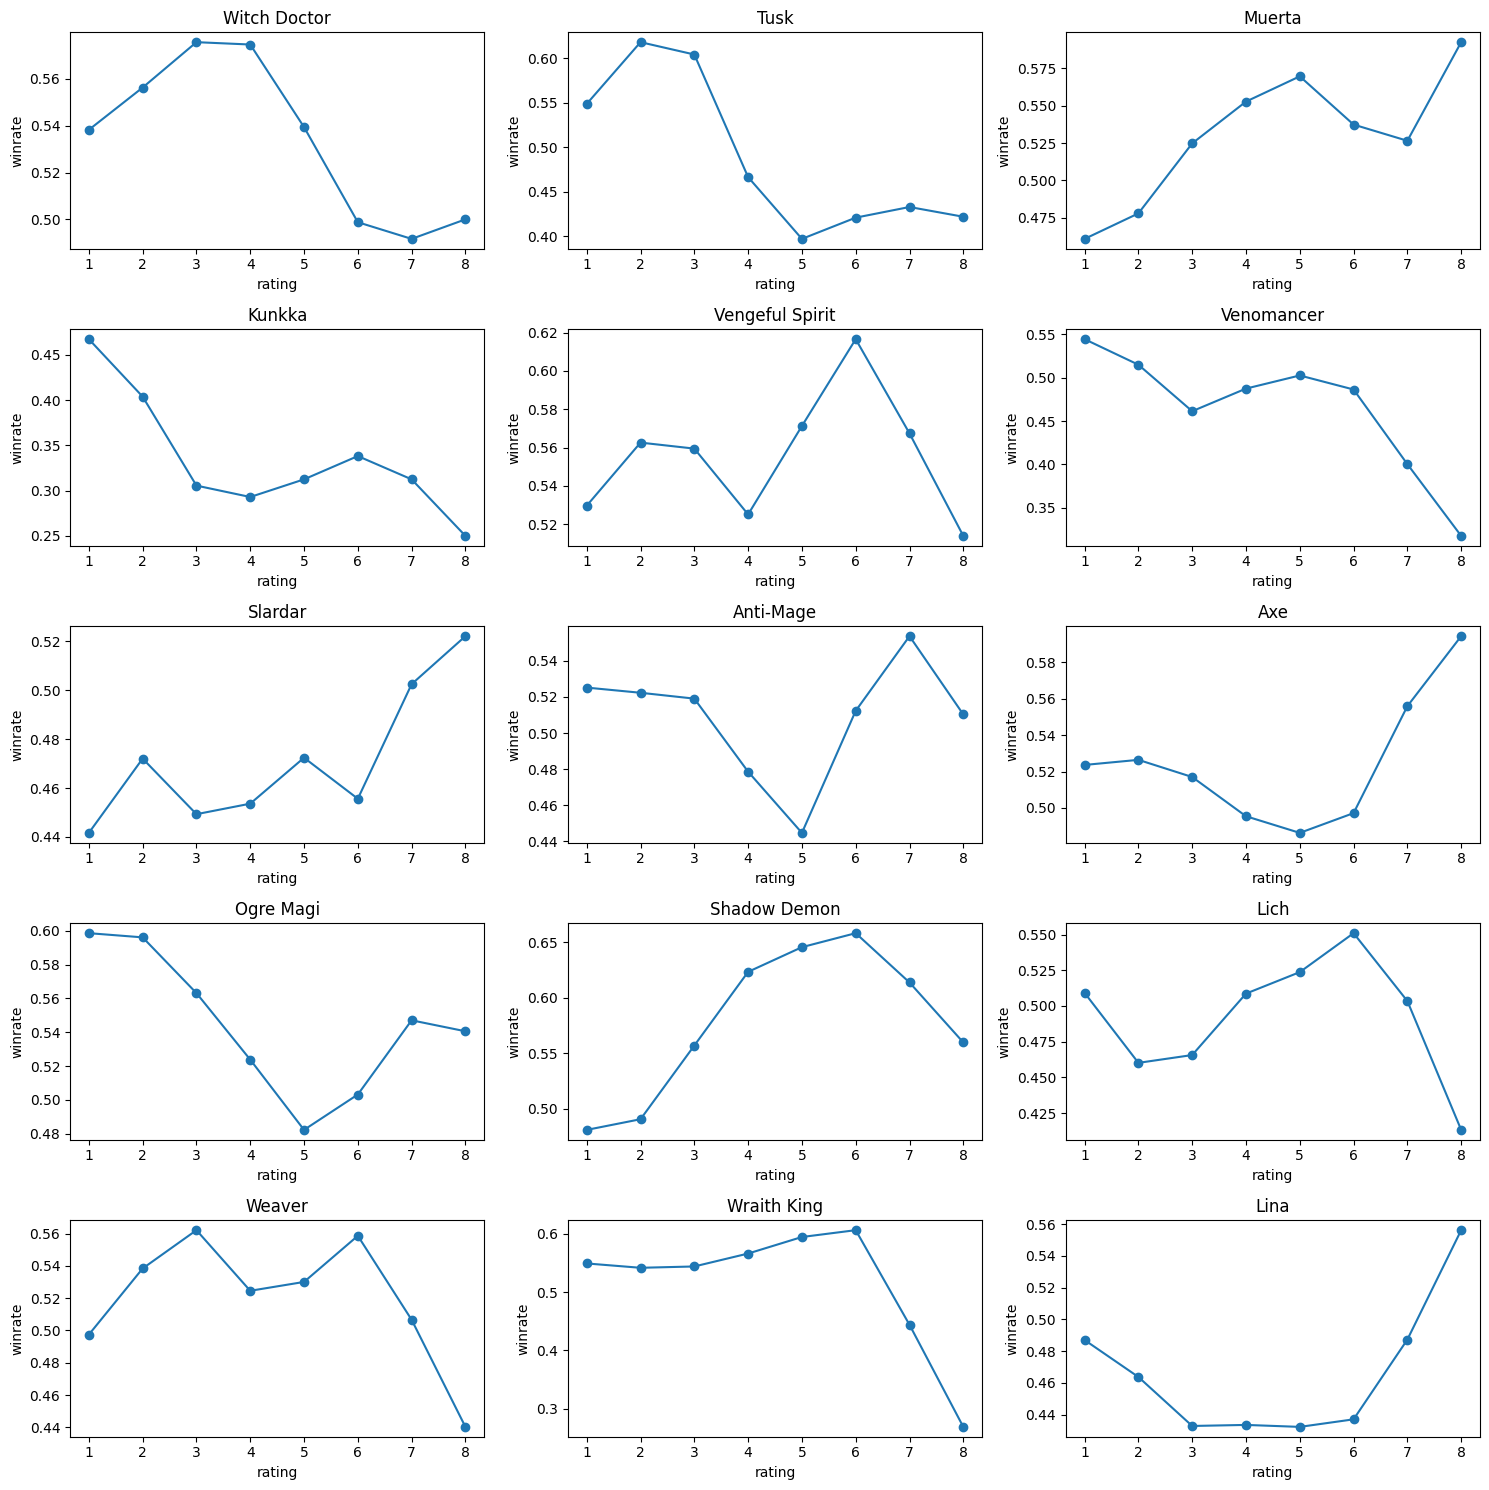

In [137]:
def plot_data(ax, data, title):
    x = sorted(data.keys())[1:-1]
    y = list(winrate[hero][i] for i in x)
    ax.plot(x, y, marker='o', linestyle='-')
    ax.set_title(title)
    ax.set_xlabel('rating')
    ax.set_ylabel('winrate')

with open('data/constants/heroes.json')as f:
    heroes = load(f)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
for i, hero in enumerate(list(winrate)[:15]):
    plot_data(axes[i % 5][i // 5], winrate[hero], heroes[str(hero)]['localized_name'])
plt.tight_layout()
plt.show()